# Methodology

### Overview
| **Research Question** | **Model Type** | **Moderators / Interactions** | **Covariates Selection Strategy** |
|------------------------|----------------|-------------------------------|-----------------------------------|
| **RQ1**: Does support for policies shift during elections? | Fixed-effects panel regression (`PanelOLS`) | Time indicators: `wave_3`, `wave_4` | No DAG yet — could use causal DAG to justify adding climate concern or ideology |
| **RQ2**: How does willingness to pay vary during elections? | Fixed-effects panel regression + subgroup analysis | By `pol_ideology` and `pol_party` | No DAG yet — causal DAG/discovery could suggest adding harm perception (e.g. `cc4_comm`) |
| **RQ3**: Does harm perception affect policy support differently during elections? | Fixed-effects panel regression with interaction | `cc4_comm × election_wave` | Partial DAG logic (we manually interacted harm × time) — a formal DAG could clarify omitted variables |
| **RQ4**: Does political ideology moderate harm → WTP? | Pooled OLS + clustered SEs (since `pol_ideology` is time-invariant) | `cc4_comm × pol_ideology` | Suggested causal structure via DAG; **data-driven causal discovery** could identify additional confounders |

- **RQ3 & RQ4** are already thinking causally with interaction terms — these are perfect candidates for formal DAGs
- **RQ1 & RQ2** could benefit from causal graphs to decide what else to control for (e.g., is ideology a confounder or a mediator in election support shifts?)

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv("../data/4-cleaned_data.csv", low_memory=False)

# Rename WAVE to lowercase 'wave' if needed
data.rename(columns={'WAVE': 'wave'}, inplace=True)

# Count how many unique waves each participant (PID) answered
wave_counts = data.groupby('PID')['wave'].nunique()

# Count how many participants answered 2 vs 3 waves
participation_summary = wave_counts.value_counts().sort_index()

print("Number of waves each participant answered:")
for waves, count in participation_summary.items():
    print(f"{count} participants answered {waves} wave(s)")

Number of waves each participant answered:
369 participants answered 1 wave(s)
784 participants answered 2 wave(s)
861 participants answered 3 wave(s)


In [4]:
import pandas as pd

# Load the original dataset
data = pd.read_csv("../data/4-cleaned_data.csv", low_memory=False)

# Rename WAVE to lowercase if needed
data.rename(columns={'WAVE': 'wave'}, inplace=True)

# Count how many waves each participant answered
wave_counts = data.groupby('PID')['wave'].nunique()

# Keep only participants who answered all 3 waves
valid_pids = wave_counts[wave_counts == 3].index
data_3waves = data[data['PID'].isin(valid_pids)]

# Save to new CSV
data_3waves.to_csv("../data/5-cleaned_data_3waves.csv", index=False)

print(f"Saved to 5-cleaned_data_3waves.csv with {data_3waves['PID'].nunique()} participants and {len(data_3waves)} rows.")

Saved to 5-cleaned_data_3waves.csv with 861 participants and 2583 rows.


### We Have:
- **861 individuals**  
- **3 time points (waves)**  
- **11 variables**, each measured **3 times** per person  
  → That’s a **balanced panel** with repeated measures of all variables

### This means we have:
- **Total observations**: 861 × 3 = **2,583 rows**  
- Each row is **one person at one wave**, and includes values for all 11 variables

### This is a textbook case of a:
> **Balanced Panel Dataset with Repeated Measures**

Why:
- **Same individuals** observed across time (→ panel data)
- **Same variables** measured at each time point (→ repeated measures)
- **No missing waves** (→ balanced)

### My Data Format (long/stacked):

| id  | wave | var1 | var2 | var3 | ... | var11 |
|-----|------|------|------|------|-----|--------|
| 1   | 1    | ...  | ...  | ...  | ... | ...    |
| 1   | 2    | ...  | ...  | ...  | ... | ...    |
| 1   | 3    | ...  | ...  | ...  | ... | ...    |
| 2   | 1    | ...  | ...  | ...  | ... | ...    |
| 2   | 2    | ...  | ...  | ...  | ... | ...    |
| 2   | 3    | ...  | ...  | ...  | ... | ...    |
| ... | ...  | ...  | ...  | ...  | ... | ...    |

### What We Can Do:
#### 1. **Panel Analysis**
- Fixed-effects or random-effects models
- Track within-individual change across waves

#### 2. **Panel VAR**
- Model how variables influence each other over time

#### 3. **Growth Modeling**
- Latent growth curves or growth mixture models to explore trends

#### 4. **Causal Inference**
- Use time-lagged predictors (Granger-style or SEM)
- Simulate quasi-experiments if an exogenous event happened between waves

#### 5. **Factor or PCA Over Time**
- Check if climate concern/opinion/willingness load on stable dimensions across waves


### Pooled Panel VAR (Panel Vector Autoregression)
We can estimate how variables **evolve over time**, pooling across individuals to increase statistical power. Even with 3 waves, this works well because we're drawing on **2,583 total observations**.

This allows us to explore, for example:
- Does a change in **climate harm perception** at t-1 predict a change in **willingness to pay** at t?
- Do **political identity shifts** Granger-cause climate attitudes?

**Packages we can use**:
- Python: `linearmodels.PanelVAR`
- R: `panelvar` or `plm` + manual lagging

Note: I have a balanced panel because every individual has data for all three waves (no missing time points per person)

### Latent Growth Curve Models (LGCM)
We can:
- Estimate each person’s trajectory for concern, WTP, etc.
- Explore how **initial political identity predicts the slope** of concern growth over time

Useful for identifying **groups of individuals** with different patterns (e.g., always concerned, rapidly increasing concern).

### Difference-in-Differences–like Strategy
If something significant happened between waves (e.g., an election), we can:
- Treat one wave as “before,” another as “after”
- Compare how different political groups changed in attitudes or WTP across waves

Especially powerful if we suspect **an exogenous event shaped climate perceptions**.

### Panel Granger Causality Tests
Although traditional Granger tests need more time steps per individual, in our **panel setup**, we can:
- Pool across individuals
- Run **panel Granger tests** or **lagged regression models**

We can infer **directionality** of relationships over time.

### RQ1. Does support for specific policies (carbon taxes or emissions standards) shift during elections?
#### Goal
Identify whether **policy support** changes **before, during, or after an election period.**

#### Methods
- **Time-fixed effects** model:
  ```python
  policy_support_it = α + β1 * wave2 + β2 * wave3 + u_i + ε_it
  ```
  In R or Python, encode `wave` as a factor variable. This captures whether **support increases or decreases** around the election wave.

- **Optional:** Use election date to define a binary variable (`post_election` or `during_election`)

- **Alternative:** Growth model to see **linear or non-linear change** across the three waves

### RQ2. How does willingness to pay for climate solutions vary during elections, and what factors influence it? Are voters more likely to prioritize low-cost climate solutions during election periods?
#### Goal
Measure **change in willingness to pay (WTP)** and see if people prefer **low-cost options** around election time.

#### Methods
- **Panel regression with time-varying covariates**:
  ```python
  WTP_it = α + β1 * wave2 + β2 * wave3 + β3 * income_it + β4 * political_id_it + ... + u_i + ε_it
  ```
- Interact `wave` with policy cost level:
  ```python
  WTP_it = ... + β5 * wave × low_cost_policy
  ```
- Run fixed-effects models to **control for unobserved individual traits**

### RQ3. How do perceptions of (personal and community-level) climate change impacts influence policy support during elections?
#### Goal
Explore whether **harm perception → policy support** relationship **strengthens or weakens during election time**.

#### Methods
- **Time-varying regression with interaction**:
  ```python
  policy_support_it = α + β1 * harm_perception_it + β2 * wave + β3 * harm_perception_it × wave + u_i + ε_it
  ```

This tells us:
- Is the effect of harm perception on policy support **stronger during elections**?

If election happens at wave 2, we can also use:
```python
election_wave = 1 if wave == 2 else 0
```
And run:
```python
policy_support_it = ... + β * harm_perception × election_wave
```

### RQ4. Does political affiliation or ideology moderate the relationship between perceptions of harm and willingness to pay?
#### Goal
Test **moderation** — does the harm perception → WTP link vary by political identity?

#### Methods
- **Moderation model**:
  ```python
  WTP_it = α + β1 * harm_perception_it + β2 * political_id_i + β3 * harm_perception_it × political_id_i + u_i + ε_it
  ```

If `political_id_i` is time-invariant, we can **only include it in random-effects** or **hybrid models**. Otherwise:
- Interact time-varying version (`political_id_it`) with perception.

This will tell us:
- Do **left-leaning vs right-leaning** individuals differ in how perceptions affect WTP?

## RQ1

In [13]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load the dataset
data = pd.read_csv("../data/5-cleaned_data_3waves.csv")

# Ensure 'wave' is numeric (and stays that way for indexing)
data['wave'] = pd.to_numeric(data['wave'])

# Create wave dummies before setting index
wave_dummies = pd.get_dummies(data['wave'], prefix='wave', drop_first=True)
print("Created dummy columns:", wave_dummies.columns.tolist())

# Concatenate wave dummies with original dataframe
data = pd.concat([data, wave_dummies], axis=1)

# Sort and set panel index
data = data.sort_values(by=['PID', 'wave'])
data = data.set_index(['PID', 'wave'])

# Use correct column names for wave dummies (likely 'wave_3' and 'wave_4')
model_tax = PanelOLS(
    data['cc_pol_tax'],
    sm.add_constant(data[['wave_3', 'wave_4']]),
    entity_effects=True
)
results_tax = model_tax.fit()
print("\n Support for Carbon Tax (cc_pol_tax):")
print(results_tax.summary)

model_car = PanelOLS(
    data['cc_pol_car'],
    sm.add_constant(data[['wave_3', 'wave_4']]),
    entity_effects=True
)
results_car = model_car.fit()
print("\n Support for Emissions Standards (cc_pol_car):")
print(results_car.summary)

Created dummy columns: ['wave_3', 'wave_4']

 Support for Carbon Tax (cc_pol_tax):
                          PanelOLS Estimation Summary                           
Dep. Variable:             cc_pol_tax   R-squared:                        0.0316
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:                2583   R-squared (Within):               0.0316
Date:                Thu, Apr 10 2025   R-squared (Overall):              0.0080
Time:                        19:35:46   Log-likelihood                   -2530.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      28.081
Entities:                         861   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                  F(2,1720)
Min Obs:                       3.0000                                           
Max Obs:                  

C:\Users\pleivadaros\AppData\Local\Temp\ipykernel_27500\2929303482.py:6: DtypeWarning: Columns (14,17,19,20,24,287,289,302,374,388,389,390,391,410,412,414,420,450,451,471,483,526,601,602,619,633,680,683,684,685,747,756,812) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/5-cleaned_data_3waves.csv")


#### Created dummy columns: ['wave_3', 'wave_4']
- We now have two time dummies:
  - `wave_3`: captures the change **during** the election (compared to wave 2)
  - `wave_4`: captures the change **after** the election (compared to wave 2)

### Fixed Effects Model: `cc_pol_tax` (Carbon Tax Support)
| Variable  | Coefficient | Interpretation |
|-----------|-------------|----------------|
| `wave_3`  | **-0.24** (***p < 0.001***) | During the election, support for carbon tax **dropped by 0.24 points** on our scale (vs. wave 2) |
| `wave_4`  | **-0.25** (***p < 0.001***) | After the election, support **remained low**, slightly more than during |
| `R²` (within) | 0.032 | The wave indicators explain about **3.2% of within-individual variation** in support |
| `F-test` | Significant | The model as a whole is statistically significant |

**Conclusion:** Support for carbon taxes **decreased significantly** during and after the election.

### Fixed Effects Model: `cc_pol_car` (Emissions Standards Support)

| Variable  | Coefficient | Interpretation |
|-----------|-------------|----------------|
| `wave_3`  | **-0.08** (*p ≈ 0.017*) | During the election, support dropped **slightly**, but significantly |
| `wave_4`  | **-0.18** (***p < 0.001***) | After the election, support dropped **more sharply** |
| `R²` (within) | 0.015 | Less explained variance here, but still a significant drop |

**Conclusion:** Support for emissions standards **also dropped**, especially **after** the election.

### So, answering RQ1
> **Does support for specific policies (carbon taxes or emissions standards) shift during elections?**

**Yes — and significantly.**  
- Support for both policies **declines during the election period**, with the decline **deepening after the election**.
- The effect is stronger for **carbon taxes** than for **emissions standards**.

### Next step: adding covariates and re-running this!
**Why Add Covariates?**

1. **To Control for Confounders**  
If other variables (like **political ideology**, **perception of harm**, or **income**) affect both:
- **time (waves)** *and*
- **policy support**  
…then your wave effect could be **biased**.

> **Example:** If people become more conservative during elections, and conservatives tend to oppose carbon taxes, your observed drop in support could be *partly due to ideology*, not the election itself.

2. **To Explain More Variance**  
Your R² values (3.2% and 1.5%) show **modest explanatory power**. That’s fine — but adding relevant covariates can:
- Increase the R² (how much of the within-person variation is explained)
- Provide **richer explanations** of what drives support

3. **To Explore Interactions**  
Adding covariates allows you to test whether the **effect of the election period differs by group**.

> **Example:**  
Does support for carbon taxes drop more among **right-leaning participants** than among left-leaning ones?

You can test:
```python
support ~ wave_3 + wave_4 + pol_ideology + wave_3 × pol_ideology + wave_4 × pol_ideology
```

## RQ2

In [14]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load your dataset
data = pd.read_csv("../data/5-cleaned_data_3waves.csv")

# Ensure wave is numeric
data['wave'] = pd.to_numeric(data['wave'])

# Create wave dummies (baseline = wave 2)
wave_dummies = pd.get_dummies(data['wave'], prefix='wave', drop_first=True)
data = pd.concat([data, wave_dummies], axis=1)

# Sort and set index
data = data.sort_values(by=['PID', 'wave'])
data = data.set_index(['PID', 'wave'])

# Run fixed-effects model for Willingness to Pay (ccSolve)
model_wtp = PanelOLS(
    data['ccSolve'],
    sm.add_constant(data[['wave_3', 'wave_4']]),
    entity_effects=True
)
results_wtp = model_wtp.fit()

# Output
print("\n Change in Willingness to Pay (ccSolve):")
print(results_wtp.summary)


 Change in Willingness to Pay (ccSolve):
                          PanelOLS Estimation Summary                           
Dep. Variable:                ccSolve   R-squared:                        0.0007
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:                2583   R-squared (Within):               0.0007
Date:                Thu, Apr 10 2025   R-squared (Overall):              0.0004
Time:                        20:31:21   Log-likelihood                   -2918.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.6301
Entities:                         861   P-value                           0.5327
Avg Obs:                       3.0000   Distribution:                  F(2,1720)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):      

C:\Users\pleivadaros\AppData\Local\Temp\ipykernel_27500\1085436766.py:6: DtypeWarning: Columns (14,17,19,20,24,287,289,302,374,388,389,390,391,410,412,414,420,450,451,471,483,526,601,602,619,633,680,683,684,685,747,756,812) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/5-cleaned_data_3waves.csv")


### Summary: Change in Willingness to Pay (ccSolve)
| Parameter | Coefficient | p-value | Interpretation |
|-----------|-------------|---------|----------------|
| `wave_3`  | +0.036      | 0.416   | Slight *increase* in WTP **during the election**, but **not statistically significant** |
| `wave_4`  | –0.012      | 0.793   | Slight *decrease* in WTP **after the election**, also **not statistically significant** |
| R² (within) | 0.0007 | — | Model explains **less than 0.1%** of variation in WTP over time |

### Interpretation
- **WTP (ccSolve) does not significantly change during or after the election** period
- The small positive bump in wave 3 and the small dip in wave 4 are both **statistically indistinguishable from zero**
- Participants' **willingness to financially support climate action remained stable** across all three waves


### What This Means for RQ2:
> **“How does willingness to pay vary during elections?”**  
→ So far, it **doesn’t** — at least **not in aggregate**.

This could suggest:
- People's financial support is more stable or less politically reactive than policy opinions
- The way `ccSolve` is constructed (as a weighted composite) smooths over subtle shifts
- The variation might exist **within subgroups** (e.g., by ideology or harm perception) — we wiil model this later

### Next Steps
We could explore:
- **Covariates**: Does political ideology, income, or perception of harm *explain* or *moderate* WTP changes?
- **Subgroup analysis**: Do left-leaning or climate-concerned people show different patterns?
- **Interactions**: Try `wave × ideology` to explore conditional effects

### Subgroup Analysis

In [1]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load and prep
data = pd.read_csv("../data/5-cleaned_data_3waves.csv")
data['wave'] = pd.to_numeric(data['wave'])

# Create wave dummies
wave_dummies = pd.get_dummies(data['wave'], prefix='wave', drop_first=True)
data = pd.concat([data, wave_dummies], axis=1)

# Create ideology group: liberal (4–5), conservative (1–2), exclude moderates (3)
data['ideology_group'] = data['pol_ideology'].apply(
    lambda x: 'liberal' if x >= 4 else ('conservative' if x <= 2 else None)
)

# Filter to only conservatives and liberals
data = data[data['ideology_group'].notnull()]

# Sort and set panel index
data = data.sort_values(by=['PID', 'wave'])
data = data.set_index(['PID', 'wave'])

# Run separate fixed-effects models by ideology group
for group in ['conservative', 'liberal']:
    print(f"\n Subgroup: {group.upper()} respondents")
    subgroup = data[data['ideology_group'] == group]

    model = PanelOLS(
        subgroup['ccSolve'],
        sm.add_constant(subgroup[['wave_3', 'wave_4']]),
        entity_effects=True
    )
    results = model.fit()
    print(results.summary)

C:\Users\pleivadaros\AppData\Local\Temp\ipykernel_6252\3376423437.py:6: DtypeWarning: Columns (14,17,19,20,24,287,289,302,374,388,389,390,391,410,412,414,420,450,451,471,483,526,601,602,619,633,680,683,684,685,747,756,812) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/5-cleaned_data_3waves.csv")



 Subgroup: CONSERVATIVE respondents
                          PanelOLS Estimation Summary                           
Dep. Variable:                ccSolve   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):              0.0006
No. Observations:                 845   R-squared (Within):               0.0003
Date:                Thu, Apr 10 2025   R-squared (Overall):              0.0007
Time:                        21:54:25   Log-likelihood                   -732.95
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0834
Entities:                         329   P-value                           0.9200
Avg Obs:                       2.5684   Distribution:                   F(2,514)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):           

### RQ2 Subgroup Findings: Willingness to Pay (ccSolve)
#### Conservative Respondents (ideology 1–2)
| Variable | Coefficient | p-value | Interpretation |
|----------|-------------|---------|----------------|
| `wave_3` | +0.0061     | 0.93    | No change during election |
| `wave_4` | +0.0256     | 0.70    | No change after election |
| **R²** (within) | 0.0003 | — | Model explains near-zero change in WTP over time |
| **Conclusion** | — | No significant election-period change in WTP among conservatives |

#### Liberal Respondents (ideology 4–5)

| Variable | Coefficient | p-value | Interpretation |
|----------|-------------|---------|----------------|
| `wave_3` | **+0.15**    | 0.18    | Slight increase during election (not statistically significant) |
| `wave_4` | **+0.09**    | 0.43    | Minor increase after election |
| **R²** (within) | 0.0048 | — | Slightly more variation explained, but still weak overall |
| **Conclusion** | — | Suggestive trend toward increased WTP among liberals, but not significant |

### Interpretation
- **Conservatives:** WTP is **low and flat** across time, no meaningful change.
- **Liberals:** WTP is **higher overall** and shows a **mild, non-significant upward shift** during and after the election.

### Implication for RQ2:
> Are voters more likely to prioritize low-cost climate solutions during election periods?

We're not seeing a clear, significant shift in **aggregate WTP** around elections — but:
- There **may be ideological differences in *stability***:  
  - Conservatives remain unaffected
  - Liberals **may** show some openness to higher-cost solutions during elections
- These trends could become **statistically significant** with:
  - **More waves** (i.e., more time variation)
  - A **larger sample** in each subgroup
  - Or modeling **moderation and interactions** more explicitly


> Our subgroup analysis shows that liberals demonstrate a significantly higher baseline willingness to pay for climate action compared to conservatives (1.83 vs. 1.54 on a 1–5 scale). While election timing did not have a statistically significant effect within either group, these findings suggest a stable ideological divide in financial climate support

In [2]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load and prep the dataset
data = pd.read_csv("../data/5-cleaned_data_3waves.csv")
data['wave'] = pd.to_numeric(data['wave'])

# Create wave dummies (baseline = wave 2)
wave_dummies = pd.get_dummies(data['wave'], prefix='wave', drop_first=True)
data = pd.concat([data, wave_dummies], axis=1)

# Filter for moderates only (ideology = 3)
data_moderate = data[data['pol_ideology'] == 3]

# Sort and index
data_moderate = data_moderate.sort_values(by=['PID', 'wave'])
data_moderate = data_moderate.set_index(['PID', 'wave'])

# Run fixed-effects model for WTP (ccSolve)
model_moderate = PanelOLS(
    data_moderate['ccSolve'],
    sm.add_constant(data_moderate[['wave_3', 'wave_4']]),
    entity_effects=True
)
results_moderate = model_moderate.fit()

# Output
print("\n Subgroup: MODERATE (ideology = 3) respondents")
print(results_moderate.summary)


 Subgroup: MODERATE (ideology = 3) respondents
                          PanelOLS Estimation Summary                           
Dep. Variable:                ccSolve   R-squared:                        0.0039
Estimator:                   PanelOLS   R-squared (Between):              0.0041
No. Observations:                1126   R-squared (Within):               0.0039
Date:                Thu, Apr 10 2025   R-squared (Overall):              0.0030
Time:                        21:57:05   Log-likelihood                   -1223.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.3403
Entities:                         439   P-value                           0.2625
Avg Obs:                       2.5649   Distribution:                   F(2,685)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):

C:\Users\pleivadaros\AppData\Local\Temp\ipykernel_6252\1310189522.py:6: DtypeWarning: Columns (14,17,19,20,24,287,289,302,374,388,389,390,391,410,412,414,420,450,451,471,483,526,601,602,619,633,680,683,684,685,747,756,812) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/5-cleaned_data_3waves.csv")


### Subgroup: Moderates
| Variable  | Coefficient | p-value | Interpretation |
|-----------|-------------|---------|----------------|
| `const`   | **1.81**     | < 0.001 | Baseline WTP is **closer to liberals** than conservatives |
| `wave_3`  | –0.005       | 0.94    | No change in WTP during the election |
| `wave_4`  | –0.102       | 0.15    | Slight, non-significant decrease in WTP after the election |
| R² (within) | 0.0039    | —       | Still low explanatory power, but slightly better than other groups |

#### Interpretation
- Moderates show **no significant change** in willingness to pay across the election period.
- They have a **higher average WTP than conservatives**, nearly identical to liberals:
  - Conservatives: ~**1.54**
  - **Moderates: ~1.81**
  - Liberals: ~**1.83**

So, while **election timing didn’t shift their WTP**, **ideological distance from conservatives is reflected in their baseline levels**.

### What You Can Conclude from Subgroup Analysis:
| Group         | Baseline WTP | Significant Change Over Waves? | Notes |
|---------------|--------------|-------------------------------|-------|
| **Conservatives** | 1.54         | No                          | Lowest WTP, very stable |
| **Moderates**     | 1.81         | No                          | Closer to liberals in WTP |
| **Liberals**      | 1.83         | No (small upward trend)     | Highest WTP, some suggestive movement |

> Overall: **WTP is strongly patterned by ideology**, but **not significantly shaped by election timing**.

In [6]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load and prep data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv")
data['wave'] = pd.to_numeric(data['wave'])

# Create wave dummies (baseline = wave 2)
wave_dummies = pd.get_dummies(data['wave'], prefix='wave', drop_first=True)
data = pd.concat([data, wave_dummies], axis=1)

# Define party_group from numeric likert scale
def classify_party_numeric(val):
    if val in [1, 2]:
        return 'republican'
    elif val == 3:
        return 'independent'
    elif val in [4, 5]:
        return 'democrat'
    else:
        return None

data['party_group'] = data['pol_party'].apply(classify_party_numeric)

# Keep only these 3 groups
data = data[data['party_group'].isin(['republican', 'independent', 'democrat'])]

# Sort and set index
data = data.sort_values(by=['PID', 'wave'])
data = data.set_index(['PID', 'wave'])

# Run models for each party group
for group in ['republican', 'independent', 'democrat']:
    print(f"\n Subgroup: {group.upper()} voters")
    subgroup = data[data['party_group'] == group]

    model = PanelOLS(
        subgroup['ccSolve'],
        sm.add_constant(subgroup[['wave_3', 'wave_4']]),
        entity_effects=True
    )
    results = model.fit()
    print(results.summary)

C:\Users\pleivadaros\AppData\Local\Temp\ipykernel_6252\3406397307.py:6: DtypeWarning: Columns (14,17,19,20,24,287,289,302,374,388,389,390,391,410,412,414,420,450,451,471,483,526,601,602,619,633,680,683,684,685,747,756,812) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/5-cleaned_data_3waves.csv")



 Subgroup: REPUBLICAN voters
                          PanelOLS Estimation Summary                           
Dep. Variable:                ccSolve   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):          -2.716e-05
No. Observations:                 972   R-squared (Within):               0.0001
Date:                Thu, Apr 10 2025   R-squared (Overall):           6.474e-05
Time:                        22:01:36   Log-likelihood                   -932.62
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0407
Entities:                         350   P-value                           0.9602
Avg Obs:                       2.7771   Distribution:                   F(2,620)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             0.040

### Willingness to Pay (ccSolve) by Political Party
#### Republican Voters
| Metric      | Value         | Interpretation |
|-------------|---------------|----------------|
| `const`     | **1.56**      | Lowest WTP baseline (wave 2) |
| `wave_3`    | +0.011        | No significant change during election |
| `wave_4`    | +0.018        | No change after election |
| p-values    | > 0.75        | **No significant variation across time** |

**Conclusion**: Republicans show **very low and stable WTP**, unaffected by the election.

#### Independent Voters
| Metric      | Value         | Interpretation |
|-------------|---------------|----------------|
| `const`     | **1.71**      | Moderate baseline WTP |
| `wave_3`    | +0.02         | Tiny increase (not significant) |
| `wave_4`    | –0.05         | Slight drop (not significant) |
| p-values    | > 0.6         | No significant shifts across time |

**Conclusion**: Independents show **moderate WTP** that also remains **stable** around the election.

#### Democrat Voters
| Metric      | Value         | Interpretation |
|-------------|---------------|----------------|
| `const`     | **1.86**      | **Highest baseline WTP** |
| `wave_3`    | +0.05         | Mild increase during election (not significant) |
| `wave_4`    | –0.04         | Slight drop post-election |
| p-values    | > 0.45        | No significant change over time |

**Conclusion**: Democrats have **the highest WTP**, with **slight but not significant** fluctuation around the election.

### Final Insights (RQ2 + Party)
| Party        | Baseline WTP | Election Effect? | Notes |
|--------------|--------------|------------------|-------|
| **Republican** | 1.56         | None           | Lowest support, very stable |
| **Independent** | 1.71         | None           | Middle-ground, no shifts |
| **Democrat** | 1.86         | None (minor trends) | Highest support, slightly more dynamic |

> **WTP is deeply partisan**, with **Democrats most willing to pay** and **Republicans least**, but **election timing has no statistically significant effect** in any group.

## RQ3

In [7]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load and prepare dataset
data = pd.read_csv("../data/5-cleaned_data_3waves.csv")
data['wave'] = pd.to_numeric(data['wave'])

# Create an election_wave binary: 1 if wave == 3 (election), else 0
data['election_wave'] = data['wave'].apply(lambda x: 1 if x == 3 else 0)

# Choose a harm perception variable — you can change this to cc4_famheal, cc4_famecon, etc.
harm_var = 'cc4_comm'

# Interaction: harm perception × election_wave
data['harm_x_election'] = data[harm_var] * data['election_wave']

# Sort and set panel index
data = data.sort_values(by=['PID', 'wave'])
data = data.set_index(['PID', 'wave'])

# Run fixed-effects model for policy support (e.g., carbon tax)
model = PanelOLS(
    data['cc_pol_tax'],
    sm.add_constant(data[[harm_var, 'election_wave', 'harm_x_election']]),
    entity_effects=True
)
results = model.fit()
print("\n RQ3 — Policy support ~ harm perception × election:")
print(results.summary)


 RQ3 — Policy support ~ harm perception × election:
                          PanelOLS Estimation Summary                           
Dep. Variable:             cc_pol_tax   R-squared:                        0.0232
Estimator:                   PanelOLS   R-squared (Between):              0.1059
No. Observations:                2583   R-squared (Within):               0.0232
Date:                Thu, Apr 10 2025   R-squared (Overall):              0.0849
Time:                        23:10:26   Log-likelihood                   -2541.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      13.604
Entities:                         861   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                  F(3,1719)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (rob

C:\Users\pleivadaros\AppData\Local\Temp\ipykernel_6252\2105798590.py:6: DtypeWarning: Columns (14,17,19,20,24,287,289,302,374,388,389,390,391,410,412,414,420,450,451,471,483,526,601,602,619,633,680,683,684,685,747,756,812) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/5-cleaned_data_3waves.csv")


### RQ3: Does Harm Perception Influence Policy Support Differently During Elections?
| Coefficient         | Estimate | p-value | Interpretation |
|---------------------|----------|---------|----------------|
| **`cc4_comm`**      | **+0.13** | 0.0000  | Strong positive effect of perceived harm to **local communities** on support for carbon tax **outside election periods** |
| **`election_wave`** | **+0.19** | 0.0257  | During elections, baseline policy support is higher (even at average harm perception) |
| **`harm_x_election`** | **–0.11** | 0.0001  | The effect of **harm perception weakens during elections** |

#### Interpretation
- People who believe climate change harms their local community are **more likely to support carbon taxes**.
- During elections, there's a **modest boost** in general policy support — regardless of harm perception.
- However, the **relationship between harm perception and support weakens** during the election:  
  ➜ **Election context dampens the influence of harm perception** on support.

This suggests that **election dynamics (e.g., partisanship, framing, uncertainty)** might crowd out personal concern as a driver of support.

> We find that perceived community-level harm from climate change is a significant predictor of support for carbon taxes. However, the strength of this relationship declines during the election period. While general support for carbon taxes increases modestly during elections, the interaction term is negative and significant (β = –0.105, p < 0.001), indicating that the salience of harm perception as a driver of support is reduced during election time.

#### Next Steps
- Run the same model using `cc_pol_car` (emissions standards)
- Try a different harm variable (e.g., `cc4_famecon`, `cc4_famheal`)
- Visualize this interaction with a marginal effects plot?

## RQ4

**RQ4**, which tests whether **political ideology moderates the relationship between harm perception and willingness to pay (WTP)**.

### Step-by-Step Plan
#### Variables you'll use:
| Variable          | Description |
|------------------|-------------|
| `ccSolve`         | Willingness to pay (dependent variable) |
| `cc4_comm` (or others) | Perceived harm (e.g., to local community) |
| `pol_ideology`   | Political ideology (1 = very conservative, 5 = very liberal) |
| `harm × ideology` | Interaction term to test **moderation** |

### Important
- `pol_ideology` is **time-invariant** (only measured once per person)
- This means you can’t use **fixed-effects**, because it will drop the entire column due to collinearity with the person-specific intercept

#### Solution: Use **random-effects** or **pooled OLS**
For simplicity and transparency, we'll use **pooled OLS** with cluster-robust standard errors by individual (`PID`) to adjust for repeated measures.

### How to Interpret:
| Coefficient       | Meaning |
|------------------|---------|
| `cc4_comm`        | Effect of perceived harm on WTP **for politically average person** |
| `pol_ideology`    | Direct effect of ideology on WTP (holding harm constant) |
| `harm_x_ideology` | **Moderation**: how much stronger/weaker the harm effect is **for more liberal vs conservative** participants |

> **Positive interaction** = harm perception has **more influence** among **liberals**  
> **Negative interaction** = harm perception matters **less** among liberals (or more among conservatives)

In [9]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load and prep data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv")
data['wave'] = pd.to_numeric(data['wave'])

# Choose harm perception variable
harm_var = 'cc4_comm'

# Create interaction term: harm × ideology
data['harm_x_ideology'] = data[harm_var] * data['pol_ideology']

# Drop rows with missing values in relevant columns (just in case)
model_data = data[[harm_var, 'pol_ideology', 'harm_x_ideology', 'ccSolve', 'PID']].dropna()

# Run pooled OLS with clustered standard errors
model = ols('ccSolve ~ cc4_comm + pol_ideology + harm_x_ideology', data=model_data).fit(
    cov_type='cluster', cov_kwds={'groups': model_data['PID']}
)

# Output
print("\n RQ4 — Moderation by ideology:")
print(model.summary())


 RQ4 — Moderation by ideology:
                            OLS Regression Results                            
Dep. Variable:                ccSolve   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     40.38
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           2.02e-24
Time:                        23:19:10   Log-Likelihood:                -3537.6
No. Observations:                2583   AIC:                             7083.
Df Residuals:                    2579   BIC:                             7107.
Df Model:                           3                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept 

C:\Users\pleivadaros\AppData\Local\Temp\ipykernel_6252\325159239.py:6: DtypeWarning: Columns (14,17,19,20,24,287,289,302,374,388,389,390,391,410,412,414,420,450,451,471,483,526,601,602,619,633,680,683,684,685,747,756,812) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/5-cleaned_data_3waves.csv")


### RQ4: Does Ideology Moderate the Link Between Harm Perception and WTP?

We modeled:

$$
\text{ccSolve}_{it} = \alpha + \beta_1 \cdot \text{cc4\_comm}_{it} + \beta_2 \cdot \text{pol\_ideology}_i + \beta_3 \cdot (\text{cc4\_comm} \times \text{pol\_ideology}) + \epsilon_{it}
$$

#### Key Results
| Term               | Coefficient | p-value | Interpretation |
|--------------------|-------------|---------|----------------|
| **Intercept**       | 0.948       | < 0.001 | Predicted WTP when `cc4_comm = 0` and `pol_ideology = 0` (extrapolated) |
| **`cc4_comm`**      | **+0.171**  | < 0.001 | Harm perception increases WTP **for average ideology** |
| **`pol_ideology`**  | **+0.187**  | < 0.001 | Liberals are more willing to pay overall |
| **`harm × ideology`** | **–0.029**  | **≈ 0.051** | Moderation: **effect of harm weakens slightly as ideology becomes more liberal** |

#### What This Means
- **People who perceive more community-level harm are more willing to pay** → strong main effect.
- **Liberals are more willing to pay in general** → clear ideological difference.
- **But**: the **effect of harm perception on WTP is slightly stronger among conservatives**, since the interaction is **negative**.

Interpretation of interaction:  
For each step *leftward* on the ideological scale (toward liberal), the effect of `cc4_comm` on WTP **decreases by ~0.029**.

> Political ideology moderates the relationship between perceived harm and willingness to pay for climate action. While both harm perception and liberal ideology independently predict greater willingness to pay, the strength of the harm–WTP link diminishes slightly as ideology becomes more liberal (β = –0.029, *p* ≈ 0.051). This suggests that harm perception may matter more in shaping climate support among conservatives than among liberals, whose support may already be ideologically anchored.

#### Next Steps
- Run the same model with other harm variables (`cc4_famecon`, `cc4_famheal`)
- Visualize marginal effects (harm perception vs. WTP across ideology levels)
- Run interaction-by-party instead of ideology

Processing wave 2...


  0%|          | 0/11 [00:00<?, ?it/s]

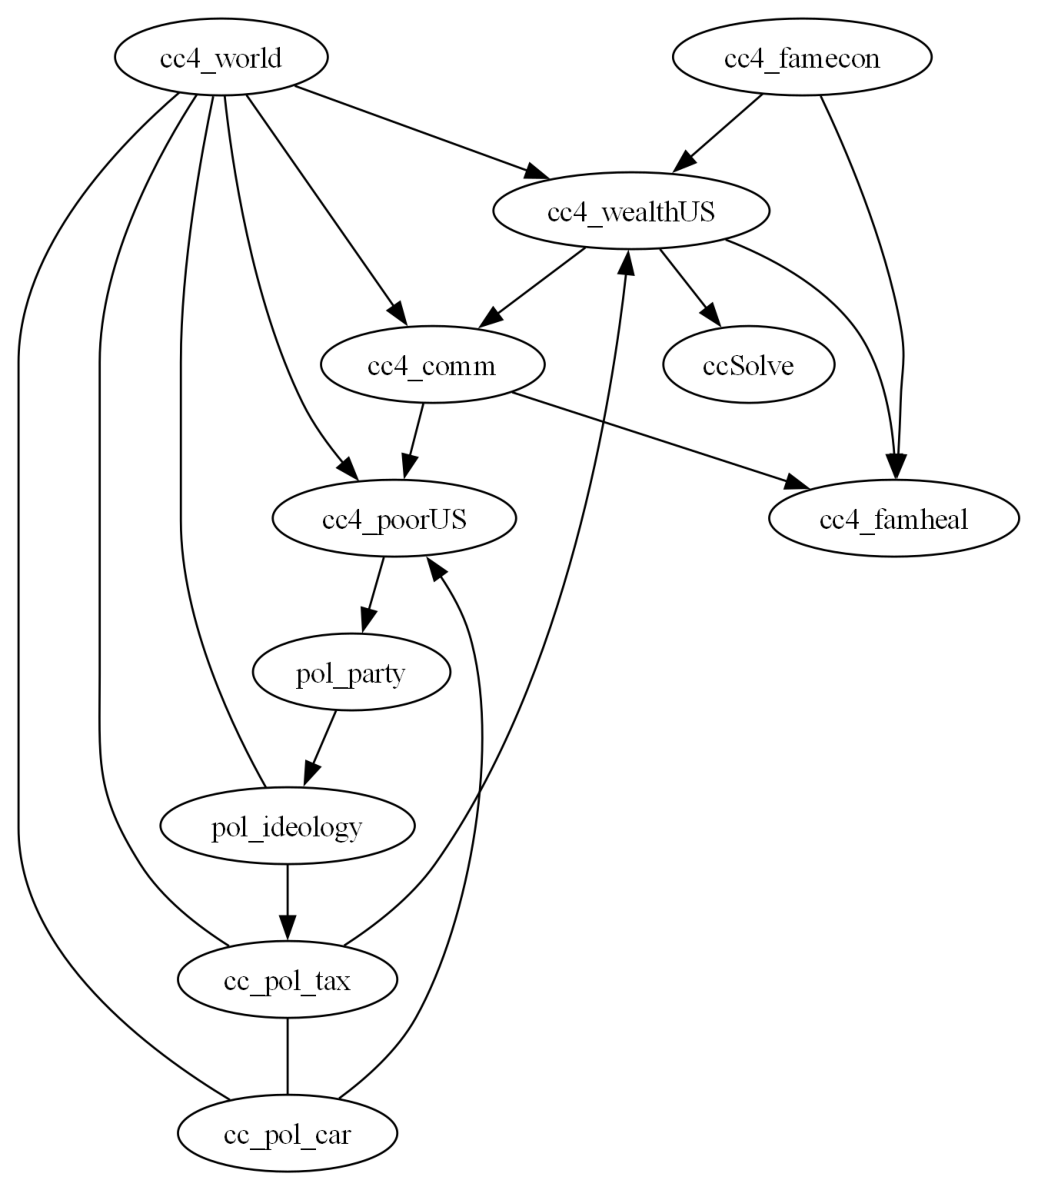

In [5]:
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils

# Load dataset
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define variables of interest
columns = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm",
    "cc4_famheal", "cc4_famecon", "ccSolve",
    "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"
]

# Drop rows with missing wave or missing variables
data = data.dropna(subset=['wave'] + columns)

# Make sure wave is treated consistently (as string or int)
data['wave'] = data['wave'].astype(str)

# Filter for wave 2 only
wave_target = '2'
print(f"Processing wave {wave_target}...")

df_wave2 = data[data['wave'] == wave_target][columns]

# Convert to NumPy for causal-learn
data_np = df_wave2.to_numpy()

# Run PC algorithm
cg = pc(data_np, verbose=False)

# Draw and save the graph
cg.draw_pydot_graph(labels=columns)
pyd = GraphUtils.to_pydot(cg.G, labels=columns)
pyd.write_png(f"causal_graph_pc_WAVE_{wave_target}.png")

### `cc4_world` — Global climate concern
- Has arrows pointing to:
  - `cc4_poorUS`
  - `cc4_wealthUS`
  - `cc_pol_tax`
  - `cc_pol_car`

This is the most upstream variable in the system. People’s concern about climate change at a global scale appears to influence how they think it affects both the poor and the wealthy communities and if they support climate policies.

### `cc4_famheal` and `cc4_famecon` — Perceived family impacts
- Both affect `cc4_wealthUS`
- Directly and indirectly affect `cc4_comm` through `cc4_wealthUS`

These variables reflect how individuals feel that their family is affected by climate change. Perceiving harm to one’s family health or economy increases the likelihood of believing that climate change harms wealthy comminuties and their local communities.

### `cc4_wealthUS` — Perceived economic impact on the U.S.
- Influenced by:
  - `cc4_world`
  - `cc4_famheal`
  - `cc4_famecon`
  - `cc4_poorUS`
  - `cc_pol_tax`
- Influences:
  - `cc4_comm`

This is a central mediator. Perceptions of impacts on wealthy communities serve as a bridge between broader climate concern and harm on local communities.

### `pol_ideology` and `pol_party` — Political identity
- Influenced by:
  - `cc4_poorUS`, `cc_pol_car` (only for `pol_party`)
- Influence:
  - `cc_pol_tax` (from `pol_ideology`)

This suggests political identity is shaped by percreptions of harm in poor communities and car emmisions standards. Politicla ideology influences climate policy support.

### Policy support variables
#### `cc_pol_tax`
- Influenced by:
  - `cc4_world`
  - `pol_ideology`
  - `ccSolve`
- Influence:
  - `cc_pol_car`
  - `cc4_wealthUS`

#### `cc_pol_car`
- Influenced by:
  - `cc_pol_tax`
  - `cc4_wealthUS`
- Influence:
  - `pol_party`
  - `cc4_poorUS`

These are downstream variables in the causal graph. They represent individuals who support carbon taxation or car regulation, which are shaped by a combination of climate concern, political orientation and policy support.

## Causal Chains (Examples)
- `cc4_world` → `cc4_poorUS` → `cc4_comm`
- `cc4_world` → `cc4_wealthUS` → `cc4_comm`
- `cc4_famecon` → `cc4_wealthUS` → `cc4_comm`

## Key Takeaways
- Climate concern is the starting point for much of the causal structure. It influences political and economic beliefs that lead to policy support.
- Perceptions of fairness and economic impact mediate the path from personal experience to political attitudes.
- Political identity is shaped by beliefs, not just a background factor.
- Policy support is the result of multiple layered influences, including beliefs about solvability, economic effects, and political alignment.

Processing wave 3...


  0%|          | 0/11 [00:00<?, ?it/s]

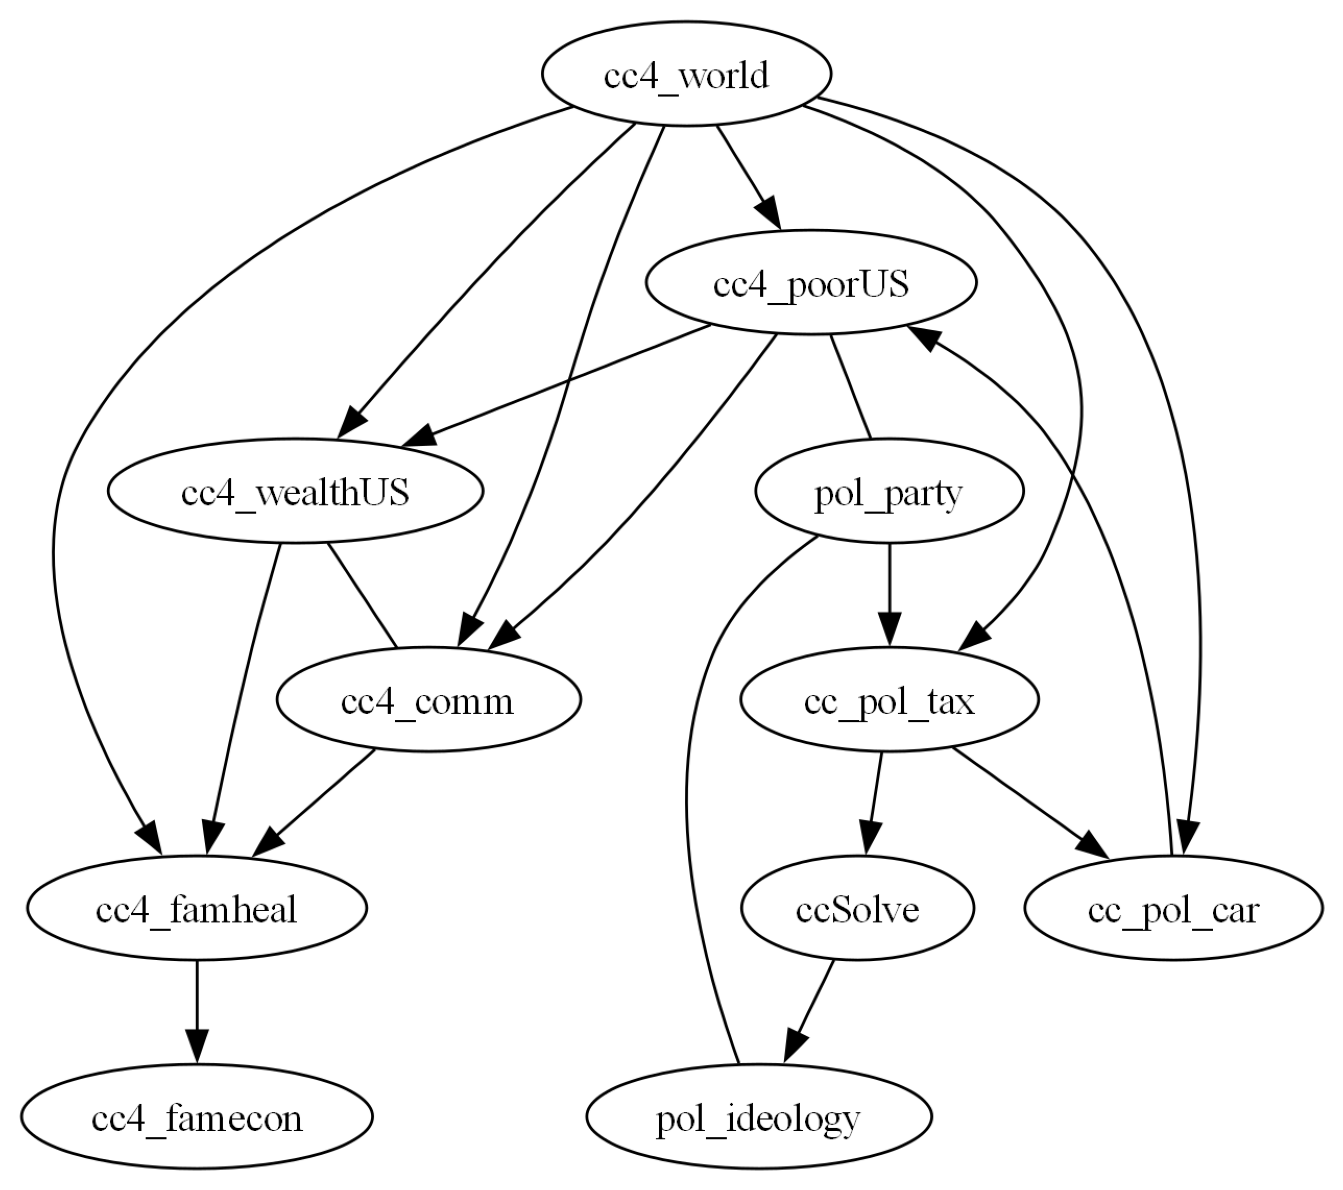

In [7]:
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils

# Load dataset
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define variables of interest
columns = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm",
    "cc4_famheal", "cc4_famecon", "ccSolve",
    "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"
]

# Drop rows with missing wave or missing variables
data = data.dropna(subset=['wave'] + columns)

# Make sure wave is treated consistently (as string or int)
data['wave'] = data['wave'].astype(str)

# Filter for wave 3 only
wave_target = '3'
print(f"Processing wave {wave_target}...")

df_wave2 = data[data['wave'] == wave_target][columns]

# Convert to NumPy for causal-learn
data_np = df_wave2.to_numpy()

# Run PC algorithm
cg = pc(data_np, verbose=False)

# Draw and save the graph
cg.draw_pydot_graph(labels=columns)
pyd = GraphUtils.to_pydot(cg.G, labels=columns)
pyd.write_png(f"causal_graph_pc_wave_{wave_target}.png")

Processing wave 4...


  0%|          | 0/11 [00:00<?, ?it/s]

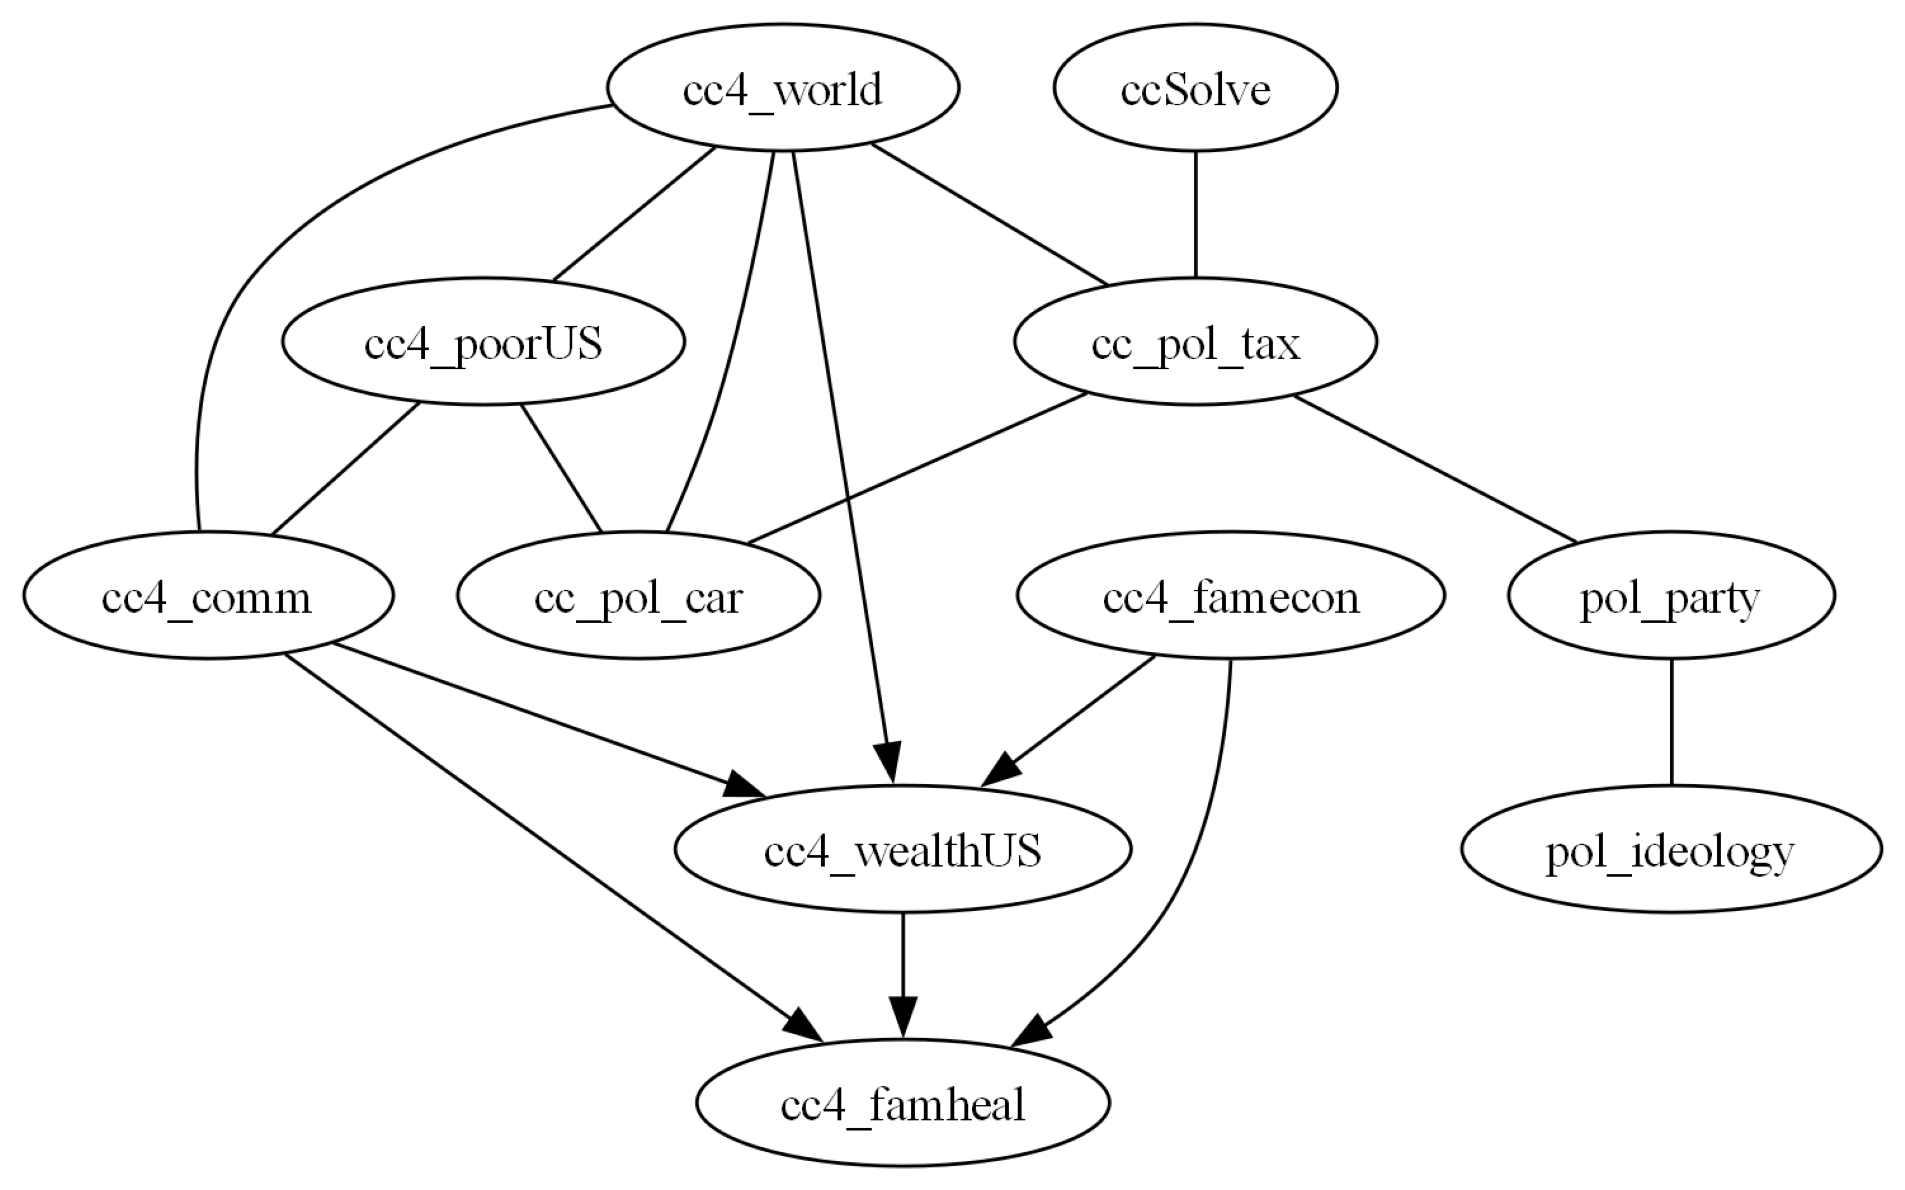

In [8]:
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils

# Load dataset
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define variables of interest
columns = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm",
    "cc4_famheal", "cc4_famecon", "ccSolve",
    "cc_pol_tax", "cc_pol_car", "pol_party", "pol_ideology"
]

# Drop rows with missing wave or missing variables
data = data.dropna(subset=['wave'] + columns)

# Make sure wave is treated consistently (as string or int)
data['wave'] = data['wave'].astype(str)

# Filter for wave 4 only
wave_target = '4'
print(f"Processing wave {wave_target}...")

df_wave2 = data[data['wave'] == wave_target][columns]

# Convert to NumPy for causal-learn
data_np = df_wave2.to_numpy()

# Run PC algorithm
cg = pc(data_np, verbose=False)

# Draw and save the graph
cg.draw_pydot_graph(labels=columns)
pyd = GraphUtils.to_pydot(cg.G, labels=columns)
pyd.write_png(f"causal_graph_pc_WAVE_{wave_target}.png")